In [1]:
import os
import random
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
gpus = tf.config.list_physical_devices( 'GPU' )
tf.config.experimental.set_memory_growth( gpus[0], True )

首先处理文件

In [3]:
path_prefix = "E:/Downloads/ChromeDownload/Speech/thchs30/data_thchs30/"
train_paths = glob(path_prefix + 'train/*.wav')
val_paths = glob(path_prefix + 'test/*.wav')

In [4]:
index_df = pd.read_csv(path_prefix+'indexs.csv',encoding='utf8')

In [5]:
pad_txts = []
for txt in index_df['txt'].values:
    t_chars = ['<']
    for char in txt:
        t_chars.append(char)
    t_chars.append('>')
    t_chars = t_chars + ['']*50
    t_chars = t_chars[:50]
    pad_txts.append(t_chars)

In [6]:
path_txt_dict = dict( zip(index_df['wav_name'].values, pad_txts) )

In [7]:
num_vocabs = 2880

string_lookup = keras.layers.StringLookup(max_tokens=num_vocabs,mask_token="")

string_lookup.adapt(pad_txts)

string_lookup_invert = keras.layers.StringLookup(vocabulary=string_lookup.get_vocabulary(), mask_token="",invert=True)

In [8]:
string_lookup.vocabulary_size()

2880

In [9]:
string_lookup.get_vocabulary()[0]

''

In [10]:
len( string_lookup.get_vocabulary() )

2880

In [11]:
def decode_spectrogram(path,sample_fre=16000):
    audio = tf.io.read_file(path)
    wav,_ = tf.audio.decode_wav(audio,1)
    wav = tf.squeeze(wav,-1)
    spectrum = tf.signal.stft(wav, frame_length=320, frame_step=160, fft_length=256)
    # 注意：这里相当于层正则化，LayerNormalization，即同一样本不同维度间的差异性更重要
    x = tf.math.pow(tf.abs(spectrum), 0.5)
    means = tf.math.reduce_mean(x,1,keepdims=True)
    stds = tf.math.reduce_std(x,1,keepdims=True)
    norm_spectrum = (x-means)/stds
    # 填充至20秒
    temporal_len = sample_fre*20; pad_len = (temporal_len-160)//160+1
    paddings = tf.constant([[0,pad_len],[0,0]])
    pad_spectrum = tf.pad(norm_spectrum, paddings, mode='CONSTANT')[:pad_len,:]
    return pad_spectrum

In [12]:
def create_ds(audio_paths,batch):
    texts = [path_txt_dict[ element.split("\\")[-1] ] for element in audio_paths]
    text_vectors = string_lookup(texts)
    text_in_vectors = text_vectors[:,:-1]
    text_out_vectors = text_vectors[:,1:]
    spectrum_ds = tf.data.Dataset.from_tensor_slices(audio_paths).map(decode_spectrogram)
    text_in_ds = tf.data.Dataset.from_tensor_slices(text_in_vectors)
    text_out_ds = tf.data.Dataset.from_tensor_slices(text_out_vectors)
    input_ds = tf.data.Dataset.zip((spectrum_ds, text_in_ds))
    ds = tf.data.Dataset.zip((input_ds, text_out_ds)).batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

In [13]:
train_ds = create_ds(train_paths[0:2000],16)
val_ds = create_ds(train_paths[2000:3000],8)

至此，以上生成Dataset

接下来，对text和频谱进行编码

In [14]:
class spectrum_embed(keras.layers.Layer):
    def __init__(self, filters=64):
        super().__init__()
        # 根据示例代码，对频谱进行卷积降维
        self.conv1 = keras.layers.Conv1D(filters,kernel_size=11,strides=2,padding='same',
                                         activation='relu', data_format='channels_last')
        self.conv2 = keras.layers.Conv1D(filters,kernel_size=11,strides=2,padding='same',
                                         activation='relu', data_format='channels_last')
        self.conv3 = keras.layers.Conv1D(filters,kernel_size=11,strides=2,padding='same',
                                         activation='relu', data_format='channels_last')
        
    def call(self,spectrum):
        x = self.conv1(spectrum)
        x = self.conv2(x)
        x = self.conv3(x)
        return x        

In [15]:
class text_embed(keras.layers.Layer):
    def __init__(self,num_vocab=1000, embed_dim=64,maxlen=49):
        super().__init__()
        self.char_embed = keras.layers.Embedding(input_dim=num_vocab, output_dim=embed_dim)
        self.position_embed = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        
    def call(self, text):
        char_embeddings = self.char_embed(text)
        seq_len = tf.shape(text)[-1]
        positions = tf.range(seq_len)
        position_embeddings = self.position_embed(text)
        embeddings = char_embeddings + position_embeddings
        return embeddings        

In [16]:
class encoder(keras.layers.Layer):
    def __init__(self,heads,embed_dim,ffn_dim,drop_rate):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([keras.layers.Dense(ffn_dim,activation='relu'),
                                    keras.layers.Dense(embed_dim)])
        self.drop1 = keras.layers.Dropout(rate=drop_rate)
        self.drop2 = keras.layers.Dropout(rate=drop_rate)
        self.ln1 = keras.layers.LayerNormalization(axis=-1,epsilon=1e-6)
        self.ln2 = keras.layers.LayerNormalization(axis=-1,epsilon=1e-6)
        
    def call(self, enc_input):
        att_out = self.att(query=enc_input, value=enc_input, attention_mask=None)
        ln1_out = self.ln1(enc_input+self.drop1(att_out, training=True))
        ffn_out = self.ffn(ln1_out)
        ln2_out = self.ln2(ln1_out+self.drop2(ffn_out, training=True))
        return ln2_out        

In [17]:
class decoder(keras.layers.Layer):
    def __init__(self,heads,embed_dim,ffn_dim,drop_rate):
        super().__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([keras.layers.Dense(ffn_dim, activation='relu'),
                                    keras.layers.Dense(embed_dim)])
        self.drop1 = keras.layers.Dropout(rate=drop_rate)
        self.drop2 = keras.layers.Dropout(rate=drop_rate)
        self.drop3 = keras.layers.Dropout(rate=drop_rate)
        
        self.ln1 = keras.layers.LayerNormalization(axis=-1,epsilon=1e-6)
        self.ln2 = keras.layers.LayerNormalization(axis=-1,epsilon=1e-6)
        self.ln3 = keras.layers.LayerNormalization(axis=-1,epsilon=1e-6)
        
    def call(self,enc_out,dec_input):
        mask = self.create_mask(dec_input)
        att1_out = self.att1(dec_input,dec_input,attention_mask=mask)
        ln1_out = self.ln1(dec_input + self.drop1(att1_out, training=True))
        att2_out = self.att2(query=ln1_out,value=enc_out,attention_mask=None)
        ln2_out = self.ln2(ln1_out + self.drop2(att2_out, training=True))
        ffn_out = self.ffn(ln2_out)
        ln3_out = self.ln3(ln2_out + self.drop3(ffn_out, training=True))
        return ln3_out
    
    def create_mask(self,query):
        batch = tf.shape(query)[0]
        seq_len = tf.shape(query)[1]
        mat1 = tf.ones([seq_len, seq_len])
        mask = tf.linalg.band_part(mat1,-1,0)[tf.newaxis,:]
        
        tiles = tf.concat([batch[tf.newaxis], tf.constant([1,1])], axis=0)
        mask = tf.tile(mask,tiles)
        return mask

In [18]:
class Transformer(keras.Model):
    def __init__(self, enc_layers=3, dec_layers=1, heads=2, embed_dim=200, ffn_dim=400, num_class=num_vocabs, maxlen= 49, drop_rate=0.1):
        super().__init__()
        self.wav_embed = spectrum_embed(embed_dim)
        self.txt_embed = text_embed(num_class,embed_dim,maxlen)
        
        self.encoders = [encoder(heads, embed_dim, ffn_dim, drop_rate) for _ in range(enc_layers)]
        self.decoders = [decoder(heads, embed_dim, ffn_dim, drop_rate) for _ in range(dec_layers)]
        
        self.classifier = keras.layers.Dense(num_class, activation='softmax') #
        
        self.myloss = keras.metrics.Mean(name='ztl_loss')
        self.myAcc = keras.metrics.Mean(name='ztl_acc')
        
        self.seq_len = maxlen
        
    def call(self, inputs):
        enc_in = inputs[0]
        dec_in = inputs[1]
        x = self.wav_embed(enc_in)
        y = self.txt_embed(dec_in)
        
        for encoder in self.encoders:
            x = encoder(x)
        
        for decoder in self.decoders:
            y = decoder(x, y)
        
        output = self.classifier(y)
        return output
        
    @property
    def metrics(self):
        return [self.myloss, self.myAcc]
    
    def train_step(self, inputs):
        input_tuple = inputs[0]
        label = inputs[1]
        mask = tf.cast( tf.math.logical_not( tf.math.equal(label,0) ), tf.float32)
        with tf.GradientTape() as tape:
            pred = self(input_tuple)
            loss = self.compiled_loss(label, pred, sample_weight=mask) #
        trainable_weights = self.trainable_variables
        gradients = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients( zip(gradients, trainable_weights) )
        self.myloss.update_state(loss)
        
        pred_ = tf.math.argmax(pred, axis=-1, output_type=label.dtype)
        myacc = tf.cast( tf.math.equal(label, pred_), tf.float32)
        myacc_ = tf.reduce_sum(tf.multiply(myacc, mask))/tf.reduce_sum(mask)
        self.myAcc.update_state(myacc_)
        
        results ={};results['张泰龙_留白'] = 0.888
        results['张泰龙_cost'] = self.myloss.result()
        results['MyAcc'] = self.myAcc.result()
        
        return results
    
    def generate(self, spectrum):
        batch = tf.shape(spectrum)[0]
        dec_in = tf.ones([batch,1],dtype=tf.int32)*3
        for i in range(self.seq_len):
            pred = self([spectrum, dec_in])
            pred_ids = tf.math.argmax(pred, axis=-1, output_type=tf.int32)[:,-1:]
            dec_in = tf.concat([dec_in, pred_ids], axis=-1)
        #tf.print(dec_in[:2,-8:])
        return dec_in

In [19]:
class MySchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,init_lr=1e-5,peak_lr=1e-3,bottom_lr=1e-5,up_epochs=15,decay_epochs=85,epoch_steps=185):
        super().__init__()
        self.init = init_lr
        self.peak = peak_lr
        self.bottom = bottom_lr
        self.ascend = up_epochs
        self.descend = decay_epochs
        self.iter_steps = epoch_steps
        
    def calculate_lr(self,epoch):
        up_lr = self.init + (self.peak - self.init)*epoch/(self.ascend-1)
        decay_lr = tf.math.maximum(self.bottom, self.peak-(self.peak - self.bottom)*(epoch - self.ascend)/self.descend )
        return tf.math.minimum(up_lr, decay_lr)
        
    def __call__(self,step):#关于形式参数：形参可以自定义名称，实参就是当前步数，会自动传入
        current_epoch = step//self.iter_steps
        #tf.print('\t The step, epoch:', step, '\t', current_epoch)
        return self.calculate_lr(current_epoch)

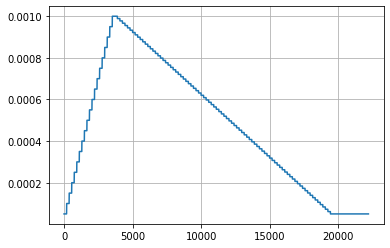

In [20]:
learning_rate = MySchedule(init_lr=5e-5,peak_lr=1e-3,bottom_lr=5e-5,up_epochs=20,decay_epochs=85,epoch_steps=185)
epochs = 120
steps_list = tf.cast(tf.range(epochs*185), tf.float32); lr_list = learning_rate(steps_list)
plt.plot(lr_list); plt.grid()

In [21]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model = Transformer()
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()],
              optimizer=optimizer)

In [22]:
model.fit(train_ds, epochs=epochs)

Epoch 1/120
125/125 [==============================] - 13s 60ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 5.3138 - MyAcc: 0.0168
Epoch 2/120
125/125 [==============================] - 7s 59ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 4.8041 - MyAcc: 0.0301 1s - 张泰龙_留白: 0.8880 - 张泰龙_cost: 4.8294 - MyAcc: 0. - ETA: 1s - 张泰龙_留白: 0.888 - ETA: 0s - 张泰龙_留白: 0.8880 - 张泰龙_cost
Epoch 3/120
125/125 [==============================] - 7s 59ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 4.4293 - MyAcc: 0.0381
Epoch 4/120
125/125 [==============================] - 7s 59ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 3.9124 - MyAcc: 0.1064
Epoch 5/120
125/125 [==============================] - 7s 59ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 3.2563 - MyAcc: 0.2456 1s - 张泰龙_留
Epoch 6/120
125/125 [==============================] - 7s 59ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 2.5764 - MyAcc: 0.3224
Epoch 7/120
125/125 [==============================] - 7s 59ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 1.9646 - MyAcc: 0.3996
Epoch 8/120
125/125 [============

125/125 [==============================] - 8s 61ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 0.1106 - MyAcc: 0.9626
Epoch 66/120
125/125 [==============================] - 8s 61ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 0.1109 - MyAcc: 0.9626
Epoch 67/120
125/125 [==============================] - 8s 61ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 0.1109 - MyAcc: 0.9622
Epoch 68/120
125/125 [==============================] - 8s 61ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 0.1108 - MyAcc: 0.9625
Epoch 69/120
125/125 [==============================] - 8s 62ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 0.1120 - MyAcc: 0.9620
Epoch 70/120
125/125 [==============================] - 8s 60ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 0.1242 - MyAcc: 0.9586
Epoch 71/120
125/125 [==============================] - 8s 64ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 0.1314 - MyAcc: 0.9569
Epoch 72/120
125/125 [==============================] - 8s 61ms/step - 张泰龙_留白: 0.8880 - 张泰龙_cost: 0.1138 - MyAcc: 0.9615
Epoch 73/120
125/125 [=======================

In [23]:
b_th = 0
for t_in, t_out in val_ds.take(1):
    b_th += 1
    t_enc_in, t_dec_in = t_in
    t_pre_ids = model.generate(t_enc_in)
    print(f"这是第{b_th}批次",'#'*80)
    t_batch = tf.shape(t_out)[0]
    for i in range( t_batch.numpy() ):
        t_shuru = ''
        print('%'*50,'前半段真实值:')
        t_pre = t_dec_in[i]
        for _ in t_pre:
            t_shuru += string_lookup.get_vocabulary()[_]
        print(t_shuru)
        t_zhenshi = ''
        print('%'*50,'真实值:')
        t_true = t_out[i]
        for _ in t_true:
            t_zhenshi += string_lookup.get_vocabulary()[_]
        print(t_zhenshi)
        print('%'*50,'预测值:')
        t_pred = ""
        for t_id in t_pre_ids[i]:
            if t_id == 2:
                break
            t_pred += string_lookup.get_vocabulary()[t_id]
        print(t_pred)

这是第1批次 ################################################################################
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 前半段真实值:
<炮眼打好了炸药怎么装岳正才咬了咬牙倏地脱去衣服光膀子冲进了水窜洞>
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 真实值:
炮眼打好了炸药怎么装岳正才咬了咬牙倏地脱去衣服光膀子冲进了水窜洞>
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 预测值:
<这种伟航牌电子灭蚊蝇灯采用某种光谱能的光效应诱杀蚊蝇和飞虫对人体无害
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 前半段真实值:
<可谁知纹完后她一照镜子只见左下眼睑的线又粗又黑与右侧明显不对称>
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 真实值:
可谁知纹完后她一照镜子只见左下眼睑的线又粗又黑与右侧明显不对称>
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 预测值:
<此外还利用这层亲缘关系稳定本厂所需钢渣矿渣来源
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 前半段真实值:
<七十年代末我外出求学母亲叮咛我吃饭要细嚼慢咽学习要深钻细研>
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 真实值:
七十年代末我外出求学母亲叮咛我吃饭要细嚼慢咽学习要深钻细研>
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 预测值:
<不是吹牛也可能是自我要求较高与我相熟的运动员大多是有追求的人
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 前半段真实值:
<一进门我被惊呆了这户名叫庞吉的老农是抗美援朝负伤回乡的老兵妻子长年有病家徒四壁一贫如洗>
%%